In [3]:
from transformers import AutoImageProcessor, AutoModel
import torch
import numpy as np
import faiss

c:\Users\HP\Desktop\E-Vision-Projects\Merchandiser_Products_Counter\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
model_name = 'facebook/dinov2-large'

In [4]:
processor = AutoImageProcessor.from_pretrained(model_name)
model  = AutoModel.from_pretrained(model_name)

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
def get_embedding(image):
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        print(outputs)
        # Use CLS token embedding
        embedding = outputs.last_hidden_state[:, 0, :].squeeze()
    return embedding.numpy()

In [1]:
from PIL import Image

In [2]:
image = '../data/test_output/cropped_image_2.jpg'
image = Image.open(image)

In [6]:
len(np.array(image).shape)

3

In [8]:
embedding = get_embedding(image)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 2.7682, -0.7520,  0.8486,  ...,  0.0129, -2.0608, -0.4539],
         [ 2.1516,  0.8273, -0.7372,  ...,  0.3455, -1.5367,  0.2737],
         [ 1.5849,  0.7777, -0.0699,  ..., -0.3213, -2.6683,  1.2853],
         ...,
         [ 0.5084, -0.4084,  0.0531,  ...,  0.8579, -0.3337, -0.0351],
         [ 0.5830, -1.3127, -0.1754,  ..., -0.6313, -0.1508,  0.0484],
         [ 1.8436, -1.8138, -0.3123,  ..., -0.6692,  0.0078,  0.4187]]]), pooler_output=tensor([[ 2.7682, -0.7520,  0.8486,  ...,  0.0129, -2.0608, -0.4539]]), hidden_states=None, attentions=None)


In [10]:
embedding

array([ 2.768203  , -0.75202346,  0.84858453, ...,  0.01292449,
       -2.0608444 , -0.45385855], shape=(1024,), dtype=float32)

In [29]:
@torch.no_grad()
def embed_images(imgs: list[Image.Image], batch_size: int = 16) -> np.ndarray:
    embs = []
    for i in range(0, len(imgs), batch_size):
        batch = imgs[i:i+batch_size]
        inputs = processor(images=batch, return_tensors="pt").to(device)
        out = model(**inputs)
        print(out)
        # Use pooled features (CLS). Shape: [B, D]
        feats = out.pooler_output
        print(feats)
        # L2 normalize for cosine similarity
        feats = torch.nn.functional.normalize(feats, dim=1)
        embs.append(feats.cpu().numpy())
    return np.vstack(embs)

In [30]:
embedding_2 = embed_images([image])

BaseModelOutputWithPooling(last_hidden_state=tensor([[[ 2.7682, -0.7520,  0.8486,  ...,  0.0129, -2.0608, -0.4539],
         [ 2.1516,  0.8273, -0.7372,  ...,  0.3455, -1.5367,  0.2737],
         [ 1.5849,  0.7777, -0.0699,  ..., -0.3213, -2.6683,  1.2853],
         ...,
         [ 0.5084, -0.4084,  0.0531,  ...,  0.8579, -0.3337, -0.0351],
         [ 0.5830, -1.3127, -0.1754,  ..., -0.6313, -0.1508,  0.0484],
         [ 1.8436, -1.8138, -0.3123,  ..., -0.6692,  0.0078,  0.4187]]]), pooler_output=tensor([[ 2.7682, -0.7520,  0.8486,  ...,  0.0129, -2.0608, -0.4539]]), hidden_states=None, attentions=None)
tensor([[ 2.7682, -0.7520,  0.8486,  ...,  0.0129, -2.0608, -0.4539]])


In [31]:
embedding_2

array([[ 0.05996584, -0.01629061,  0.01838235, ...,  0.00027998,
        -0.04464278, -0.00983165]], shape=(1, 1024), dtype=float32)

In [10]:
class TransformerEmbedding:
    def __init__(self, model_name):
        self.processor = AutoImageProcessor.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        
    def get_embedding(self, image):
        inputs = self.processor(images=image, return_tensors='pt')
        with torch.no_grad():
            outputs = self.model(**inputs)
            embed = outputs['pooler_output'].squeeze()
            # embed = embed.reshape(-1) if not use squeeze
            embed = torch.nn.functional.normalize(embed, dim=0)
        return embed.numpy()       

In [11]:
emb_model = TransformerEmbedding(model_name)

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]


In [12]:
print(image)

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=284x878 at 0x12C1B62D010>


In [13]:
out = emb_model.get_embedding(image)

In [14]:
out

array([ 0.05996584, -0.01629061,  0.01838235, ...,  0.00027998,
       -0.04464278, -0.00983165], shape=(1024,), dtype=float32)

In [15]:
DB_DIR = '../data/db'

class FaissManager:
    def __init__(self, embedding_dim):
        self.index = faiss.IndexFlatIP(embedding_dim)
        
    def add_reference_images(self, embeddings, index_path):
        vector = np.array(embeddings).astype(np.float32)
        self.index.add(vector)
        faiss.write_index(self.index, index_path)
        return self.index
    
    def load_index(self, index_path):
        self.index = faiss.read_index(index_path)
        return self.index
    
    def find_similarity(self, query_embedding, index_path, top_k = 3):
        self.index = self.load_index(index_path=index_path)
        
        query_features = query_embedding.astype(np.float32).reshape(1, -1)
        
        distances, indices = self.index.search(query_features, top_k)
        
        return distances, indices

In [16]:
import os
import glob

db_images = os.listdir(DB_DIR)
db_image_paths = glob.glob(os.path.join(DB_DIR, '*/*.jpg'))

In [17]:
class DBEmbedding:
    def __init__(self, model):
        self.image_path = []
        self.embedding_lis = []
        self.model = model
    def get_db_embedding(self, db_dir):
        self.image_path = glob.glob(os.path.join(db_dir, '*/*.jpg'))
        for img in self.image_path:
            image = Image.open(img)
            embedding = self.model.get_embedding(image)
            self.embedding_lis.append(embedding)
        return self.embedding_lis

In [18]:
embedding_db = DBEmbedding(emb_model)

In [19]:
embedding_lis = embedding_db.get_db_embedding(DB_DIR)

In [20]:
embedding_dim = len(embedding_lis[0])
embedding_dim

1024

In [21]:
faiss_manager = FaissManager(embedding_dim=embedding_dim)

In [22]:
INDEX_PATH = '../data/faiss_data/vector.index'

faiss_manager.add_reference_images(embeddings=embedding_lis, index_path=INDEX_PATH)

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x0000012BA7E5DBF0> >

In [ ]:
query_image = '../data/test_output/cropped_image_4.jpg'
query_embedding = emb_model.get_embedding(Image.open(query_image))

In [89]:
distances, indices = faiss_manager.find_similarity(query_embedding=query_embedding, index_path=INDEX_PATH)

In [90]:
distances, indices

(array([[0.38646692, 0.3428744 , 0.33464584]], dtype=float32),
 array([[29,  7,  8]]))

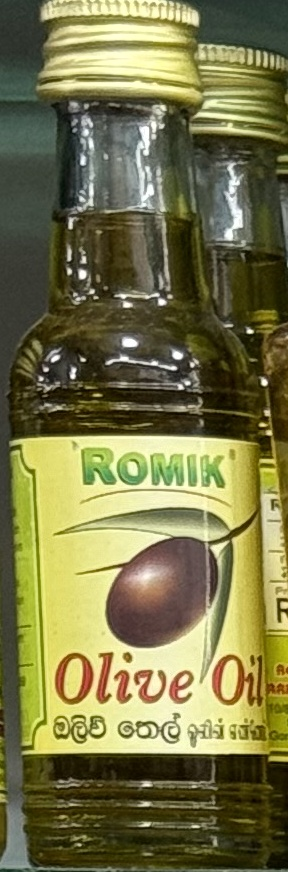

In [91]:
Image.open(query_image)

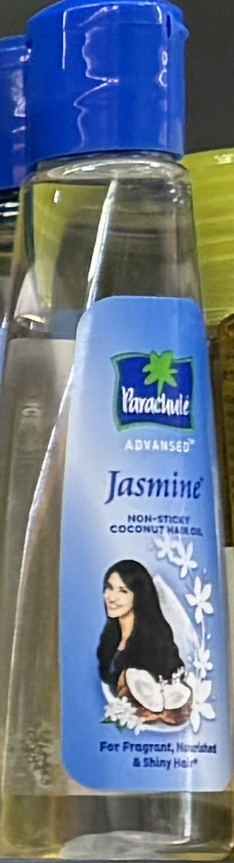

In [92]:
Image.open(db_image_paths[indices[0][0]])

In [95]:
import matplotlib.pyplot as plt 

In [93]:
query_images = glob.glob('../data/test_output/*.jpg')

In [97]:
num_images = len(query_images)

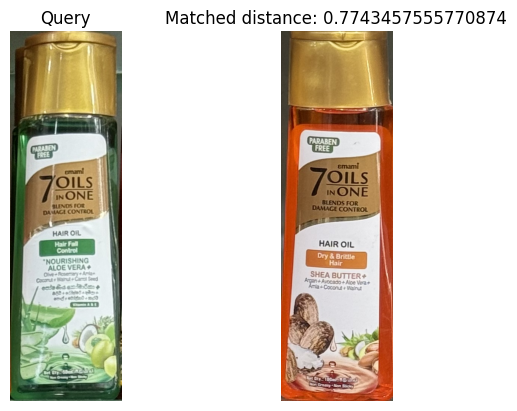

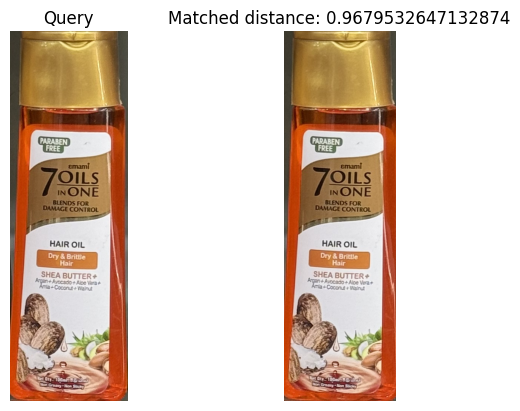

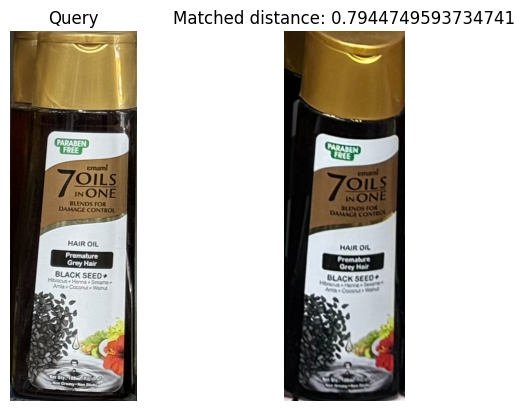

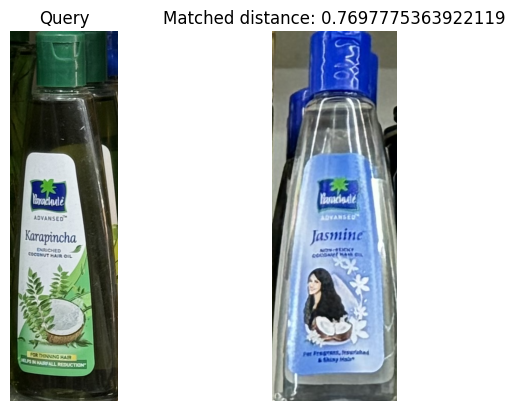

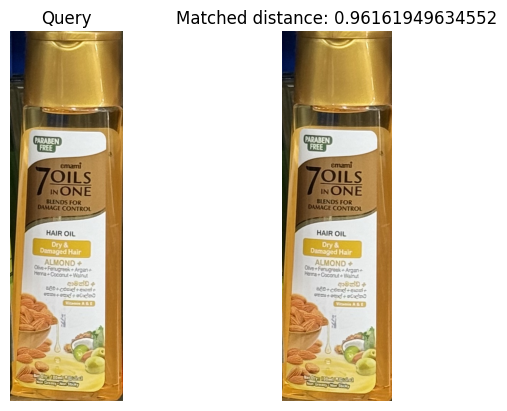

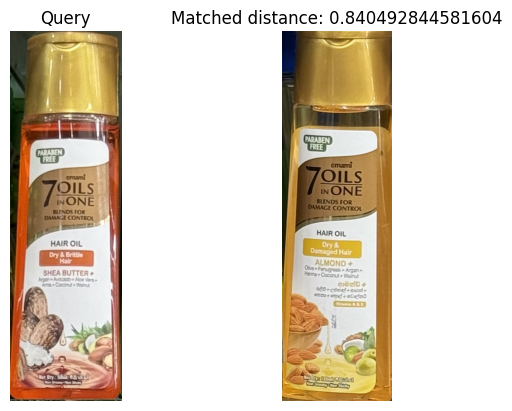

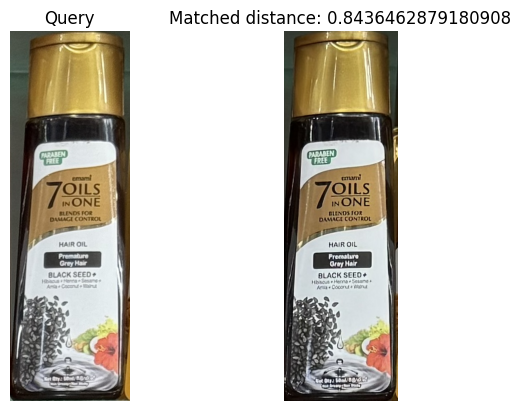

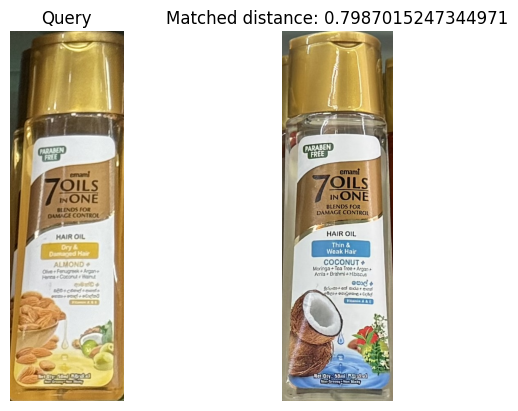

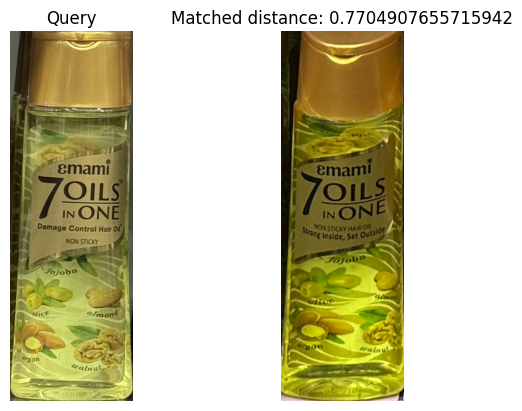

In [ ]:
for i, img in enumerate(query_images):
    query_img = Image.open(img)
    query_emb = emb_model.get_embedding(query_img)
    distances, indices = faiss_manager.find_similarity(query_embedding=query_emb, index_path=INDEX_PATH)
    matched_image = Image.open(db_image_paths[indices[0][0]])
    # if distances[0][0] < 0.75:
    #     continue
    plt.subplot(1,2,1)
    plt.imshow(query_img)
    plt.axis('off')
    plt.title("Query")
    
    plt.subplot(1,2,2)
    plt.imshow(matched_image)
    plt.axis('off')
    plt.title(f"Matched distance: {distances[0][0]}")
    plt.show()

In [1]:
import torch
from transformers import AutoImageProcessor, AutoModel
from sentence_transformers import SentenceTransformer
from PIL import Image
import requests
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

c:\Users\HP\Desktop\E-Vision-Projects\Merchandiser_Products_Counter\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Load DINOv2 for image embeddings
dinov2_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-large")
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-large").to(device)
dinov2_model.eval()

Fetching 1 files: 100%|██████████| 1/1 [00:00<?, ?it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Dinov2Model(
  (embeddings): Dinov2Embeddings(
    (patch_embeddings): Dinov2PatchEmbeddings(
      (projection): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): Dinov2Encoder(
    (layer): ModuleList(
      (0-23): 24 x Dinov2Layer(
        (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (attention): Dinov2Attention(
          (attention): Dinov2SelfAttention(
            (query): Linear(in_features=1024, out_features=1024, bias=True)
            (key): Linear(in_features=1024, out_features=1024, bias=True)
            (value): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (output): Dinov2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (layer_scale1): Dinov2LayerScale()
        (drop_path): Identity()
        (norm2): LayerNorm((1024,),

In [4]:
# Load SentenceTransformer for text embeddings
text_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2").to(device)

# Linear projection to align text embeddings with DINOv2 (384 -> 1024)
projection = nn.Linear(384, 1024).to(device)
# Initialize projection weights (this is a simple approximation; fine-tuning improves results)
nn.init.xavier_uniform_(projection.weight)
projection.eval()

Linear(in_features=384, out_features=1024, bias=True)

In [5]:
# Example: Load catalog (replace with your grocery product catalog)
catalog = pd.DataFrame({
    "SKU": ["SKU001", "SKU002", "SKU003"],
    "TextDescription": [
        "Brand: emami, Name: 7 oil in one, Color: black",
        "Brand: emami, Name: 7 oil in one, Color: Yellow",
        "Brand: Colgate, Name: Toothpaste, Color: White and Blue"
    ]
})
# For testing, use your example text descriptions
# catalog = pd.DataFrame({
#     "SKU": ["ITEM001", "ITEM002", "ITEM003"],
#     "TextDescription": ["dining chairs", "a laptop", "toothbrushes"]
# })
text_descriptions = catalog["TextDescription"].tolist()
skus = catalog["SKU"].tolist()

In [6]:
text_descriptions

['Brand: emami, Name: 7 oil in one, Color: black',
 'Brand: emami, Name: 7 oil in one, Color: Yellow',
 'Brand: Colgate, Name: Toothpaste, Color: White and Blue']

In [7]:
# Precompute text embeddings
with torch.no_grad():
    text_embeddings = text_model.encode(text_descriptions, convert_to_tensor=True, device=device)
    text_embeddings = projection(text_embeddings)  # Project to 1024 dimensions
    text_embeddings = F.normalize(text_embeddings, p=2, dim=1)  # Normalize for cosine similarity

In [8]:
# Load and process query image
query_image = '../data/test_output/cropped_image_4.jpg' # Replace with your image URL
query_image = Image.open(query_image)
# query_image = Image.open("uploaded_product.jpg").convert("RGB")  # For local file

In [9]:
# Process image with DINOv2
inputs = dinov2_processor(images=query_image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = dinov2_model(**inputs)
    image_embedding = outputs.last_hidden_state[:, 0, :]  # [CLS] token
    image_embedding = F.normalize(image_embedding, p=2, dim=1)  # Normalize

In [10]:
# Compute cosine similarities
similarities = F.cosine_similarity(image_embedding, text_embeddings)
best_match_idx = similarities.argmax().item()
matched_sku = skus[best_match_idx]
confidence = similarities[best_match_idx].item()

In [11]:
# Optional: Softmax for probabilities (similar to your example)
similarities_softmax = torch.softmax(similarities * 100, dim=-1)
confidence_softmax = similarities_softmax[best_match_idx].item()

In [12]:
print(f"Matched SKU: {matched_sku}")
print(f"Matched Description: {text_descriptions[best_match_idx]}")
print(f"Raw Cosine Similarity: {confidence:.4f}")
print(f"Softmax Probability: {confidence_softmax:.4f}")

Matched SKU: SKU003
Matched Description: Brand: Colgate, Name: Toothpaste, Color: White and Blue
Raw Cosine Similarity: 0.0255
Softmax Probability: 0.8712
